In [1]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from functools import partial
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision

from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
import numpy as np

import os
import random
import shutil
import time

import cv2
import json

from torchvision.models.detection.mask_rcnn import MaskRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

/home/csenge2/.local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
#torch.set_default_tensor_type('torch.cuda.FloatTensor')
device = torch.device("cuda:0")

In [3]:
train_json = json.load(open('mask_train.json'))
val_json = json.load(open('mask_val.json'))
test_json = json.load(open('mask_test.json'))

train_folder = '/mnt/NVME4/vizilabda_videos/Mask_RCNN/train'
val_folder = '/mnt/NVME4/vizilabda_videos/Mask_RCNN/val'
test_folder = '/mnt/NVME4/vizilabda_videos/Mask_RCNN/test'

In [4]:
class dataset(Dataset):

    def __init__(self, root,bbox_dict, ratio = 0.1,transforms = None):
        self.root = root
        self.transforms = transforms
        self.ratio = ratio
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(root)))
        if '.ipynb_checkpoints' in self.imgs:
            self.imgs.remove('.ipynb_checkpoints')
        self.bboxes = bbox_dict
    
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, self.imgs[idx])
        mask_path = os.path.join('/mnt/NVME4/vizilabda_videos/Mask_RCNN/mask',self.imgs[idx])
        img = np.asarray(Image.open(img_path).convert("RGB"))
        img = cv2.resize(img, (0,0), fx=self.ratio, fy=self.ratio) 
        mask  = np.asarray(Image.open(mask_path).convert("RGB"))
        mask = cv2.resize(mask, (0,0), fx=self.ratio, fy=self.ratio) 
        
        normd_bboxes = self.bboxes[self.imgs[idx]]
        bboxes = []
        masks = []
        for normd_bbox in normd_bboxes:
            min_y = min(round(normd_bbox[0]*img.shape[0]),round(normd_bbox[2]*img.shape[0]))
            min_x = min(round(normd_bbox[1]*img.shape[1]),round(normd_bbox[3]*img.shape[1]))
            max_y = max(round(normd_bbox[0]*img.shape[0]),round(normd_bbox[2]*img.shape[0]))
            max_x = max(round(normd_bbox[1]*img.shape[1]),round(normd_bbox[3]*img.shape[1]))
            bbox = [min_x,min_y,max_x,max_y]
            bboxes.append(bbox)
            masks.append(torch.tensor(mask/255,dtype = torch.float32))
            

        # get bounding box coordinates for each mas

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(bboxes, dtype=torch.float32)
        masks = torch.stack(masks)
        # there is only one class
        labels = torch.ones((len(bboxes),), dtype=torch.int64)
        scores = torch.ones((len(bboxes),), dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(bboxes),), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        target["masks"] = masks
        img = torch.tensor(img/255,dtype = torch.float32)
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

In [5]:
def collate_fn(batch):
        return batch

In [6]:
train_ds = dataset(train_folder,train_json,ratio=0.1)
val_ds = dataset(val_folder,val_json,ratio=0.1)
test_ds = dataset(test_folder,test_json,ratio=0.1)
train_iterator = data.DataLoader(train_ds, 
                                 batch_size = 4,collate_fn = collate_fn)
val_iterator = data.DataLoader(val_ds, 
                                batch_size = 4,collate_fn = collate_fn)
test_iterator = data.DataLoader(test_ds, 
                                batch_size = 4,collate_fn = collate_fn)

In [22]:
model=torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)  
in_features = model.roi_heads.box_predictor.cls_score.in_features 
model.roi_heads.box_predictor=FastRCNNPredictor(in_features,num_classes=2)
model.to(device)

optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3)


In [ ]:
min_loss = 10
for epoch in range(10):
    print(epoch)
    for (i,in_data) in enumerate(train_iterator):
        try:
            images = [element[0] for element in in_data]
            targets = [element[1] for element in in_data]

            images = list(torch.moveaxis(image,-1,0).to(device) for image in images)
            targets=[{k: v.to(device) for k,v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            losses.backward()
            optimizer.step()
            print(i,'loss:', losses.item())
            if i%10==0 and losses.item()<min_loss:
                min_loss = losses.item()
                torch.save(model.state_dict(), str(epoch)+'_'+str(i)+".torch")
                print("Save model to:",str(i)+".torch")
        except:
            pass

0
0 loss: 2.1347274780273438
Save model to: 0.torch
1 loss: 14.120771408081055
2 loss: 14.777238845825195
3 loss: 0.8794057369232178
4 loss: 1.4023975133895874
5 loss: 1.1940155029296875
6 loss: 1.1322249174118042
7 loss: 0.7916901111602783
8 loss: 0.7827163934707642
9 loss: 0.6810785531997681
10 loss: 0.6106542348861694
Save model to: 10.torch
11 loss: 0.755765974521637
12 loss: 0.9066215753555298
13 loss: 0.45612555742263794
14 loss: 0.3457077145576477
15 loss: 0.47178372740745544
16 loss: 0.40986528992652893
17 loss: 0.48029759526252747
18 loss: 0.6092119216918945
19 loss: 0.6238800883293152
20 loss: 0.5636124014854431
Save model to: 20.torch
21 loss: 0.5036751627922058
22 loss: 0.44018834829330444
23 loss: 0.46975022554397583
24 loss: 0.48310405015945435
25 loss: 1.7819935083389282
26 loss: 0.974672794342041
27 loss: 0.7899028062820435
28 loss: 0.4896308183670044
29 loss: 0.7295962572097778
30 loss: 0.6359789967536926
31 loss: 0.9618048071861267
32 loss: 0.7978094816207886
33 loss:

In [19]:
def superimpose_mask(image_array, mask_array, opacity=1, color_index=0):
    '''
    superimpose the binary mask on the RGB image with adjustable opacity level
    color index = 0, 1 and 2 indicates color red, green and blue in order
    '''
    superimposed = image_array.copy()
        
    colored_mask = np.zeros(image_array.shape)
    colored_mask[:, :,color_index] = mask_array == 1
    colored_mask = colored_mask.astype(np.bool)
    superimposed[colored_mask] = opacity * 1 + (1 - opacity) * superimposed[colored_mask]
    return superimposed

/opt/conda/envs/osc_new/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


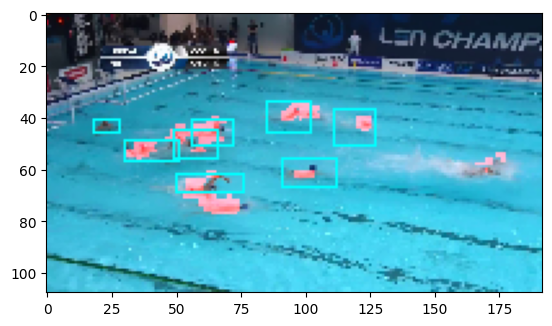

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


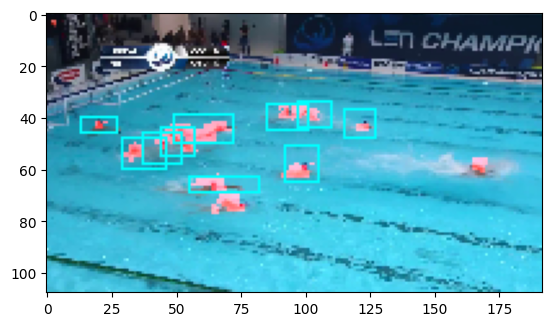

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


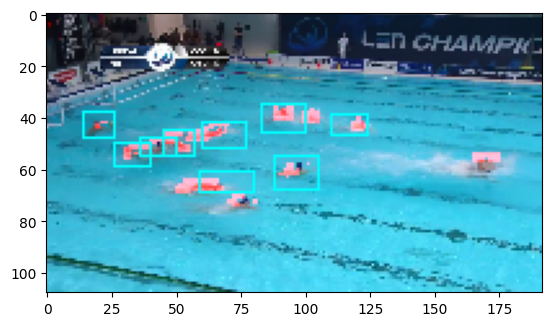

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


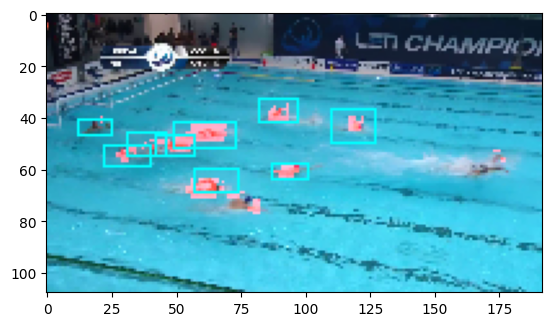

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


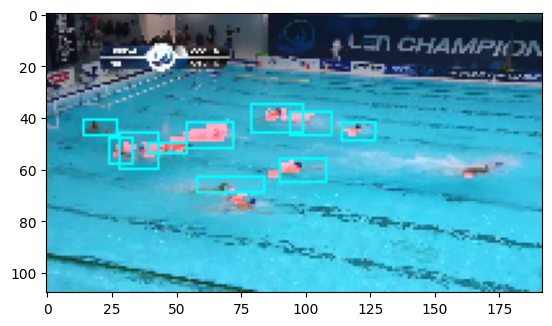

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


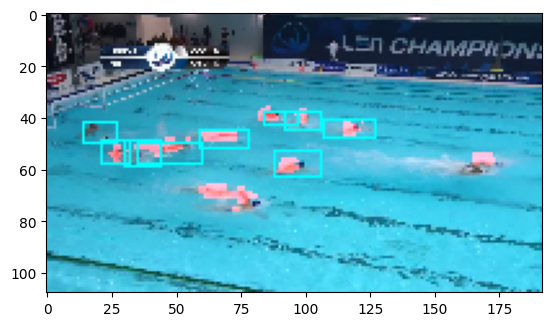

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


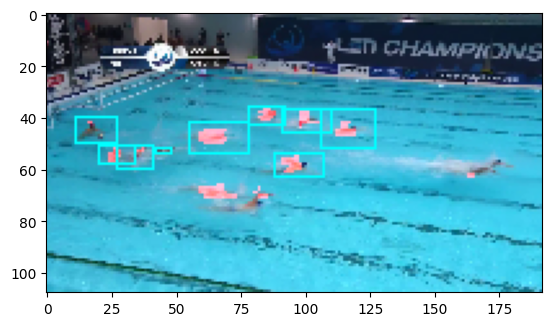

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


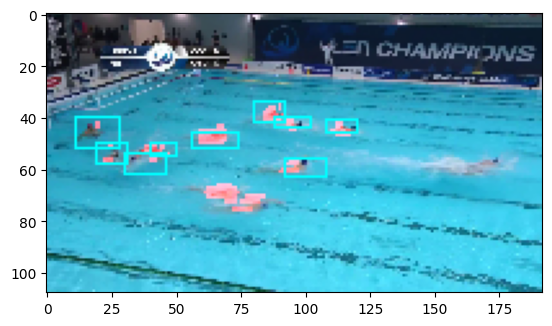

KeyboardInterrupt: 

In [21]:
import random
for i,in_data in enumerate(val_iterator):
    images = [element[0] for element in in_data]
    targets = [element[1] for element in in_data]
    im = images[0].numpy()
    #im = cv2.cvtColor(np.moveaxis(im, 0, -1), cv2.COLOR_BGR2RGB)
    pred = targets[0]
    for j in range(len(pred['masks'])):
        msk=pred['masks'][0,:,:,:].detach().cpu().numpy()
        mask = 1-cv2.inRange(msk,(0,0,0),(0,0,0))
    plt.imshow(mask)
    im = superimpose_mask(im, mask)
        
    for box in pred['boxes']:
            
        im = cv2.rectangle(im,(round(box[0].item()),(round(box[1].item()))),((round(box[2].item())),(round(box[3].item()))),color=(0,255,255),thickness=1)
        #print(pred.keys())
        #print(im1.shape,msk.shape)
        #im1[:,:,1][msk>0.5] = random.randint(0,255)
        #im1[:, :, 1][msk > 0.5] = random.randint(0,255)
        #im1[:, :, 1][msk > 0.5] = random.randint(0, 255)
    plt.imshow(im)
    plt.show()

In [ ]:
torch.save(model.state_dict(), "FINAL.torch")

In [ ]:
for i,in_data in enumerate(val_iterator):
    images = [element[0] for element in in_data]
    targets = [element[1] for element in in_data]
    im = images[0].numpy()
    pred = targets[0]
    for j in range(len(pred['masks'])):
        msk=pred['masks'][0,:,:,:].detach().cpu().numpy()
    for box in pred['boxes']:
        print(box)
        im = cv2.rectangle(im,(round(box[0].item()),(round(box[1].item()))),((round(box[2].item())),(round(box[3].item()))),color=(255,0,255),thickness=1)
        #print(pred.keys())
        #print(im1.shape,msk.shape)
        #im1[:,:,1][msk>0.5] = random.randint(0,255)
        #im1[:, :, 1][msk > 0.5] = random.randint(0,255)
        #im1[:, :, 1][msk > 0.5] = random.randint(0, 255)
    plt.imshow(np.hstack([im,msk]))
    plt.show()
    if i> 5:
        break